In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import uncrater as uc
from uncrater.utils import cordic2rad, rad2cordic, cordic_add
alpha_to_pdrift = 50e3*4096*16/102.4e6*2*np.pi*1e-6

In [298]:
import json
def read_adc(ch):
    jdata = json.load(open(f'/u/home/anze/Nov21/adc{ch}_output.json'))
    data = np.array(jdata['data'])
    data[data>8192]-=16384
    return data

ewf = [read_adc(ch+1) for ch in range(4)]

def spec(w):
    return np.abs(np.fft.rfft(w)**2)

In [330]:
C = uc.Collection("session_calibrator/cdi_output", verbose=True)
C.cut_to_hello()
Cd= C
#Cd = uc.Collection("session_calibrator/cdi_output")
#Cx = uc.Collection("session_calibrator/cdi_output")
#C.calib_data.shape

Analyzing 84 files from session_calibrator/cdi_output.
Reading  session_calibrator/cdi_output/00000_0209.bin
Reading  session_calibrator/cdi_output/00001_020f.bin
Reading  session_calibrator/cdi_output/00002_0210.bin
Reading  session_calibrator/cdi_output/00003_0211.bin
Reading  session_calibrator/cdi_output/00004_0212.bin
Reading  session_calibrator/cdi_output/00005_0213.bin
Reading  session_calibrator/cdi_output/00006_020f.bin
Reading  session_calibrator/cdi_output/00007_0210.bin
Reading  session_calibrator/cdi_output/00008_0211.bin
Reading  session_calibrator/cdi_output/00009_0212.bin
Reading  session_calibrator/cdi_output/00010_0213.bin
Reading  session_calibrator/cdi_output/00011_020f.bin
Reading  session_calibrator/cdi_output/00012_0210.bin
Reading  session_calibrator/cdi_output/00013_0211.bin
Reading  session_calibrator/cdi_output/00014_0212.bin
Reading  session_calibrator/cdi_output/00015_0213.bin
Reading  session_calibrator/cdi_output/00016_020f.bin
Reading  session_calibrator

[]

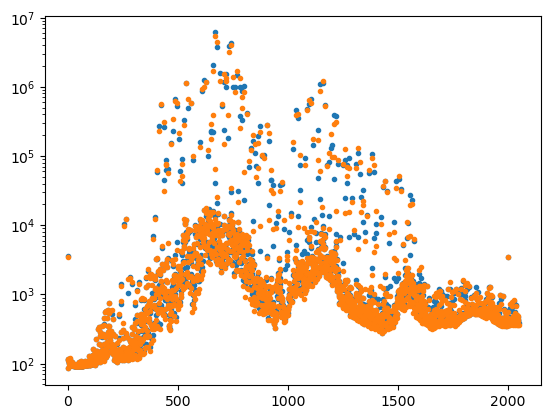

In [331]:
for i in [0,7]:
    plt.plot(np.mean(np.array([sp[2].data[:] for sp in C.spectra[i::8]]),axis=0),'.')
plt.semilogy()

28.0

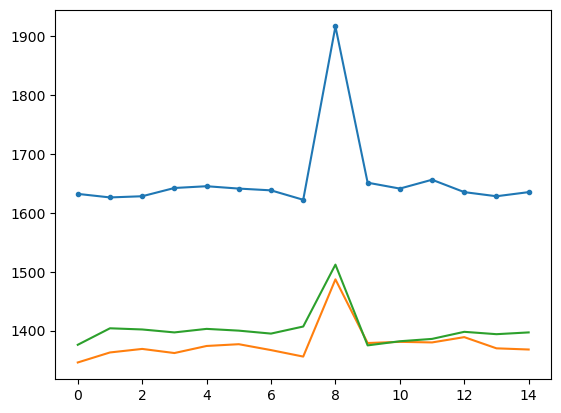

In [332]:
plt.plot([sp[2].data[1201] for sp in C.spectra],'.-')
plt.plot([sp[2].data[1202] for sp in C.spectra])
plt.plot([sp[2].data[1203] for sp in C.spectra])

13+(22-13)*25/len(C.spectra)




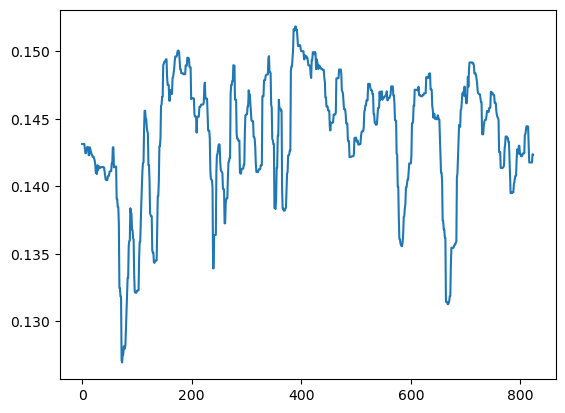

In [333]:
plt.plot(C.cd_drift[200:1200]/alpha_to_pdrift)



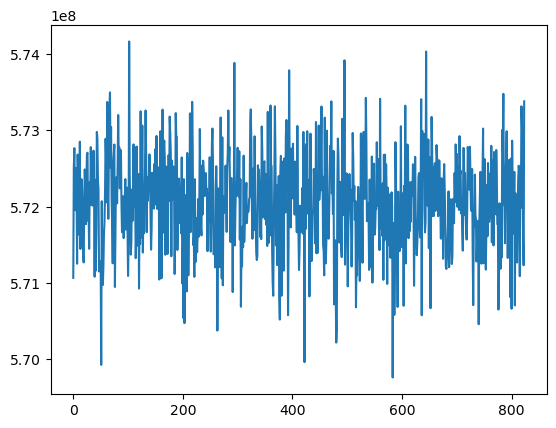

In [334]:
plt.plot (C.cd_powertop2[200:])

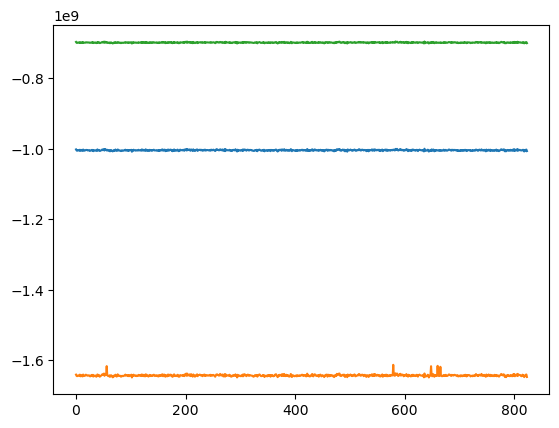

In [335]:
plt.plot(C.cd_sd1[200:])
plt.plot(C.cd_sd2[200:])
plt.plot(C.cd_sd3[200:])


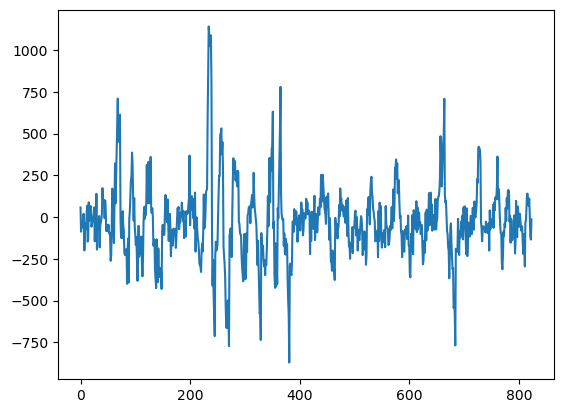

In [339]:
plt.plot (C.cd_fd3[200:])

[]

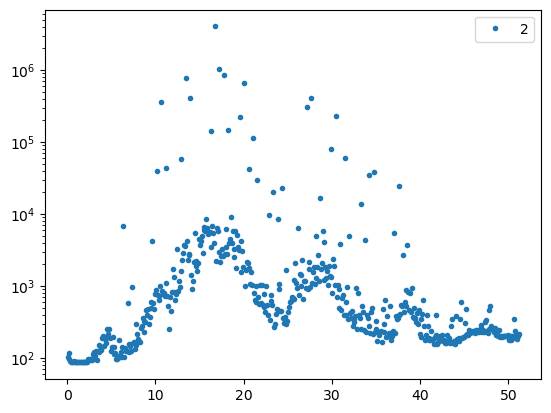

In [313]:
f = C.spectra[0][0].frequency
s0 = C.spectra[0][3].data[:]
s1 = C.spectra[1][3].data[:]
s2 = C.spectra[2][3].data[:]
#plt.plot(f,s2)
for i in [2]:
    plt.plot(f[i::4], s2[i::4],'.', label=str(i))
plt.legend()
#plt.plot(s1,'g.')
#plt.plot(s2,'b.')
#plt.plot(s1*0.001,'r.')

plt.semilogy()

Text(0, 0.5, 'power')

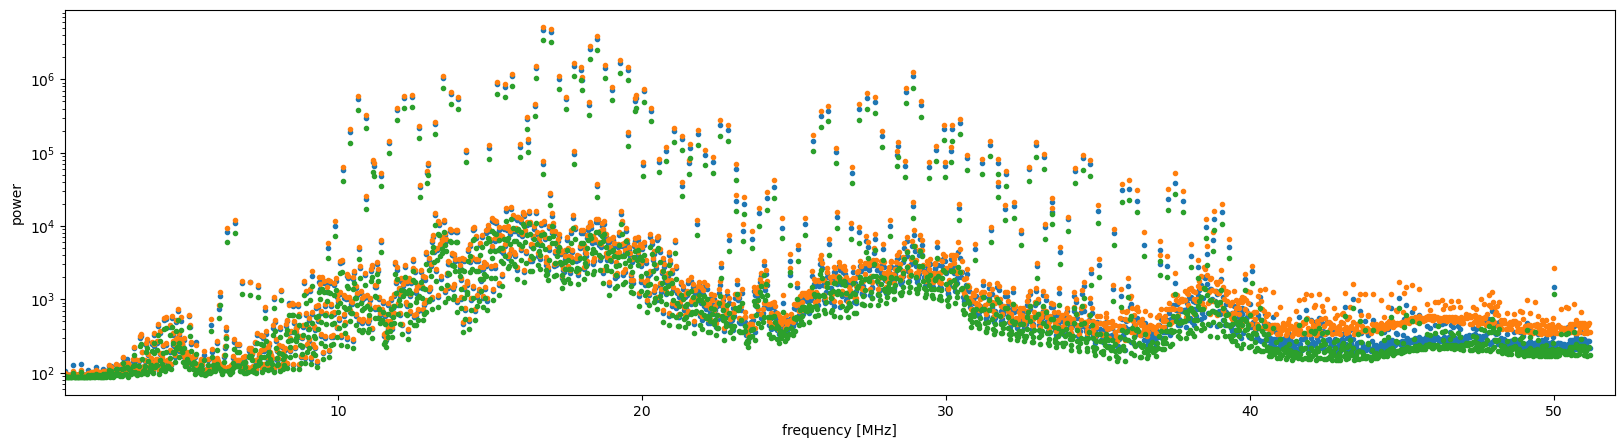

In [205]:

plt.figure(figsize=(20,5))
f = C.spectra[0][0].frequency
for i in [1,2,3]:
    s = np.mean([sp[i].data[:] for sp in C.spectra],axis=0)
    plt.plot(f,s,'.')

#plt.plot(f[2::4],s[2::4],'r.',markersize=3)
plt.xlim(1,52)
#plt.ylim(0,1e4)
#plt.ylim(3.0e6,5e6)
#plt.ylim(0.1e3,2e6)
#plt.ylim(3e6,2e7)
plt.semilogy()
plt.xlabel('frequency [MHz]')
plt.ylabel('power')

Text(0, 0.5, 'power')

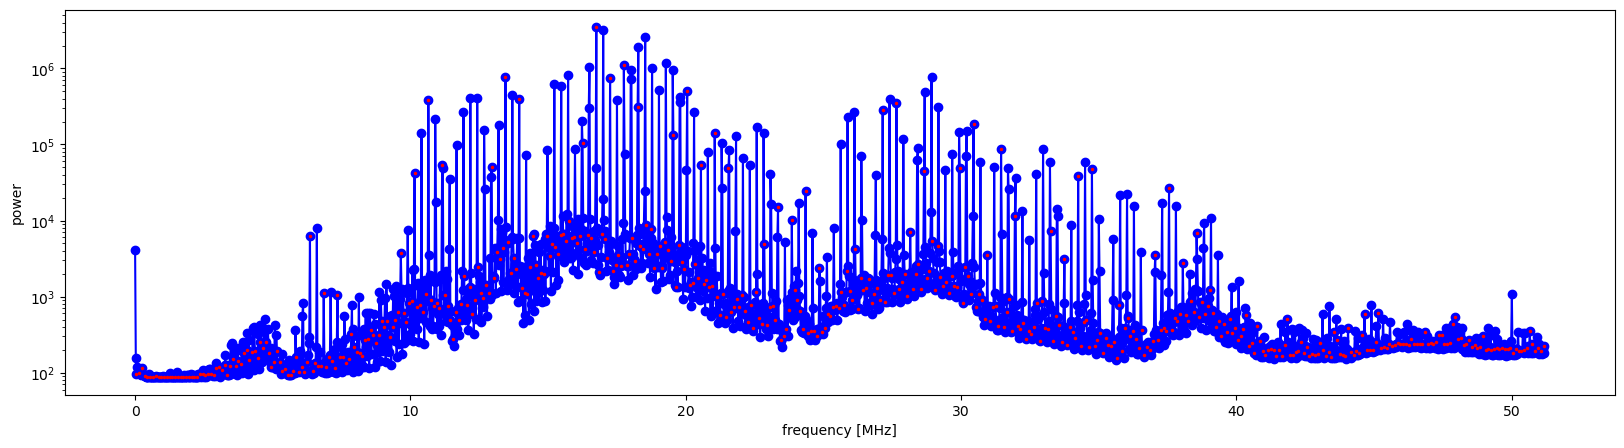

In [23]:

plt.figure(figsize=(20,5))
f = C.spectra[2][0].frequency
s = np.mean([sp[3].data[:] for sp in C.spectra],axis=0)
plt.plot(f,s,'bo-')
#plt.plot(f,s*1.03,'k-')
plt.plot(f[2::4],s[2::4],'r.',markersize=3)

#plt.ylim(0,1e4)
#plt.ylim(3.0e6,5e6)
#plt.ylim(0.1e3,2e6)
#plt.xlim(45,52)
#plt.ylim(4.65e6,5.85e6)
#plt.xlim(9,12)
#plt.ylim(3.5e6,5e6)
#plt.xlim(30,40)
#plt.ylim(4.65e6,5.85e6)


plt.semilogy()
plt.xlabel('frequency [MHz]')
plt.ylabel('power')

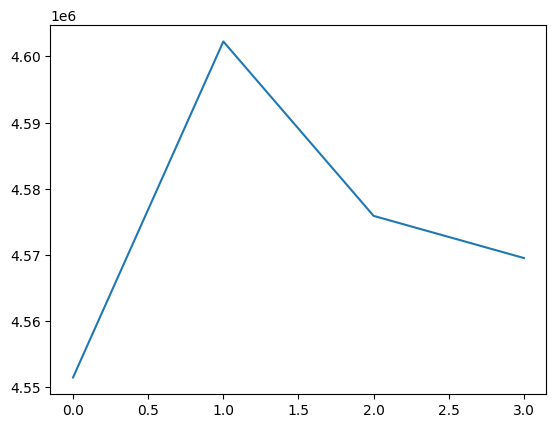

In [9]:
plt.plot(s[900::].reshape(-1,4).mean(axis=0))

array([46413.95272976, 46514.33086695, 46766.12458821, 46940.98051809,
       47195.55980174, 47302.41602709, 47313.19220894, 47457.14045326,
       47349.15268513, 47478.03677491, 47197.7213539 , 47333.3714413 ,
       46617.39105742, 46578.93469155, 46240.19664751, 45916.1890078 ,
       45246.60443613, 44355.74191692,    80.77747211,    74.16872656,
         222.55111772,   180.32470713,   219.16432191,   329.01367753,
          87.658428  ,   134.01492454,   105.11898021,   135.15176654,
         156.15697231,    90.62008607])

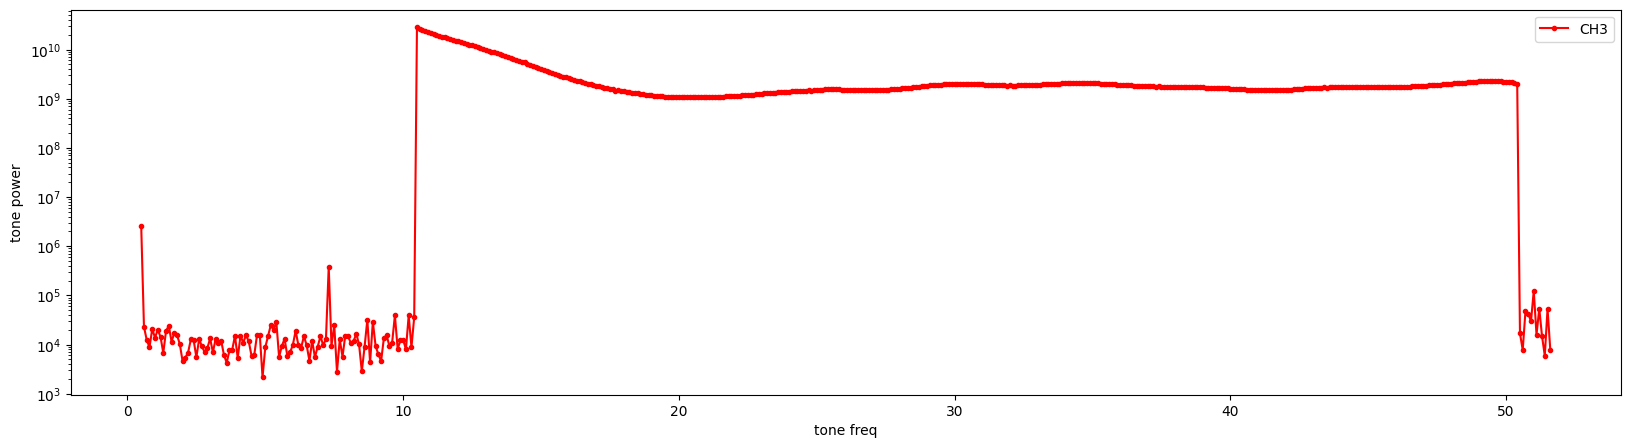

In [10]:
plt.figure(figsize=(20,5))
tfreq=0.5+0.1*np.arange(512)
for ch in range(3,4):
    plt.plot(tfreq,np.abs(C.calib_data[ch,1:,:]**2).mean(axis=0), 'r.-',label='CH'+str(ch))
    #plt.plot(np.abs(Cx.calib_data[ch,1:,:]**1).mean(axis=0), label='CH'+str(ch))

    #plt.plot(np.abs(C.calib_data[ch,1:,100:500]**1).mean(axis=0)/np.abs(Cx.calib_data[ch,1:,100:500]**1).mean(axis=0), label='CH'+str(ch))


plt.legend()
plt.xlabel('tone freq')
plt.ylabel('tone power')

#i1= np.real(C.calib_data[2,:,400])
#i2=np.imag(C.calib_data[2,:,400])
#i3= np.real(C.calib_data[3,:,400])
#plt.plot(np.imag(C.calib_data[3,:,100]))
#plt.plot(C.calib_data[0,:,400])
#plt.plot(r3**2+i3**2)

plt.semilogy()
np.abs(C.calib_data[ch,1,-30:])

In [847]:
C.gNacc
#plt.imshow(cordic2rad(C.gphase[:,:16]),aspect='auto', interpolation='nearest')
#plt.plot(C.gphase[30,:16])
#plt.plot(C.gphase[60,:16])

#plt.plot(C.calib_data[0,1,:])
#plt.plot(C.calib_data[0,60,:])


array([4, 9, 9, 4, 9, 2, 2, 4, 4])

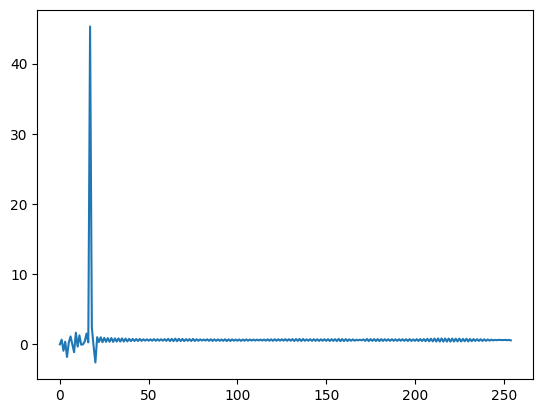

In [1099]:
plt.plot(cordic2rad(C.gphase[1:4,:255].mean(axis=0).astype(int))/alpha_to_pdrift/32)
#plt.plot(cordic2rad(C.gphase[-30:-10,:17].mean(axis=0).astype(int))/alpha_to_pdrift/32)
#plt.plot(C.gphase[-2,1:18])
#plt.plot(C.cd_fd0/C.cd_sd0)
#plt.plot(C.cd_fd1/C.cd_sd1)
#plt.plot(C.cd_fd2/C.cd_sd2)
#plt.plot(C.cd_fd3/C.cd_sd3)

#plt.plot(C.cd_fdx/C.cd_sdx)
#plt.xlim(2500,3500)
#plt.ylim(-1e-4,1e-4)

#plt
# .plot(C.cd_fdx)
#plt.xlim(3000,4000)
#plt.semilogy()


#plt.semilogy()
#C.cd_lock_ant.max()

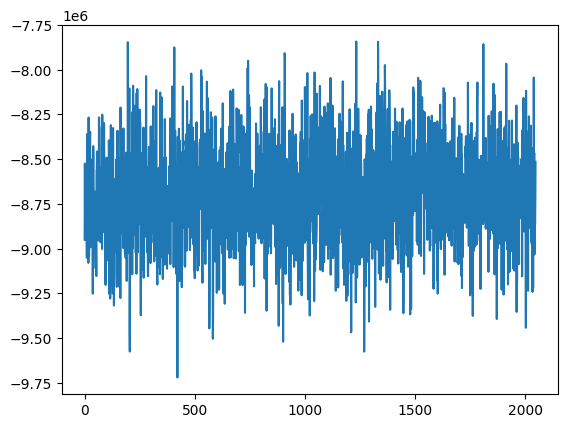

In [242]:
plt.plot(Cd.cd_sd2)


In [682]:
#plt.plot(Cd.cd_drift, Cd.cd_powertop0,'bo')
#plt.plot(Cd.cd_drift, Cd.cd_powertop1,'ro')
#plt.plot(Cd.cd_drift, Cd.cd_powertop2,'go')
#plt.plot(Cd.cd_drift, Cd.cd_powertop3,'yo')

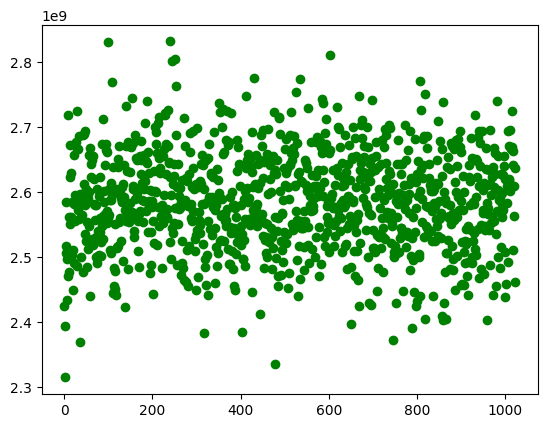

In [1134]:
#plt.plot(Cd.cd_drift, Cd.cd_powerbot0,'bo')

plt.plot(Cd.cd_powertop2,'go')
#plt.plot(Cd.cd_powerbot2,'gx')
#plt.plot(Cd.cd_powertop2/Cd.cd_powerbot2,'go')
#plt.plot(Cd.cd_drift, Cd.cd_powerbot3,'yo')

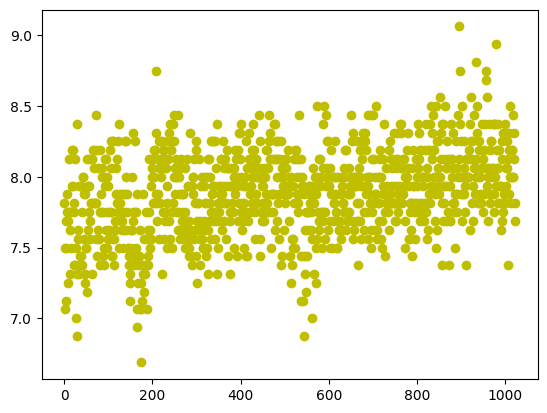

In [12]:
#plt.plot(Cd.cd_snr0,'ro')
#plt.plot(Cd.cd_snr1,'go')
plt.plot(Cd.cd_snr2/16,'yo')
#plt.plot(Cd.cd_drift, Cd.cd_powerbot3,'rx')
#plt.plot(Cd.cd_have_lock*200)
#plt.ylim(0,80)

(0.0, 100.0)

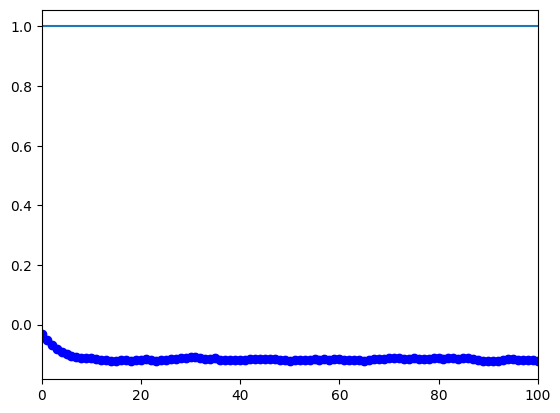

In [11]:
plt.plot(Cd.cd_drift/alpha_to_pdrift,'bo-')
plt.plot(Cd.cd_have_lock)
plt.xlim(0,100)

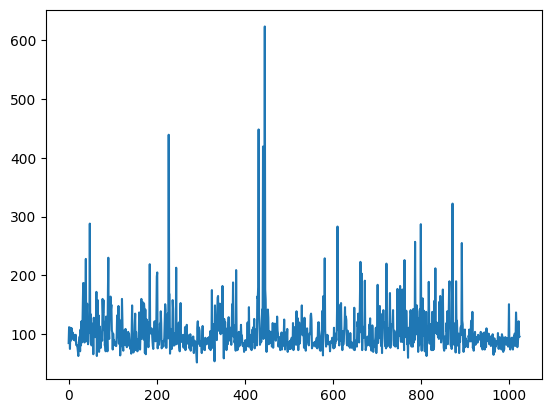

In [982]:
#plt.plot(Cd.cd_fd3/Cd.cd_sd0,'r.')   
plt.plot(Cd.cd_snr1)#/Cd.cd_sd1,'g.')   
#plt.plot(Cd.cd_fd3/Cd.cd_sd2,'b.')   
#plt.plot(Cd.cd_fd3/Cd.cd_sd3,'y.')   

#plt.xlim(-0.2,0.2)
#plt.ylim(-1e-4,1e-4)
#plt.plot(Cd.cd_drift,Cd.cd_snr0)#Cd.cd_sd0,'bo')
#plt
# .xlim(-1e-4,1e-4)
#plt.ylim(-1e-2,1e-2)

Text(0, 0.5, 'drift [ppm]')

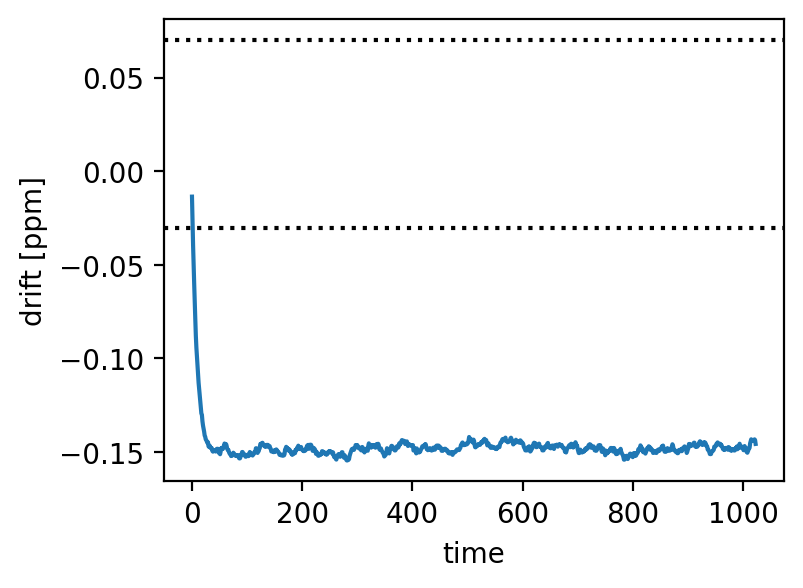

In [1110]:

plt.figure(figsize=(4,3),dpi=200)
plt.plot((Cd.cd_drift[0:]/alpha_to_pdrift))
ofs = -0.03
plt.axhline(ofs,ls=':', color='k')
plt.axhline(ofs+0.1, ls=':', color='k')
plt.xlabel('time')
plt.ylabel('drift [ppm]')
#plt.plot(C.cd_snr0)
#plt.semilogy()
##plt.ylim(-1e-5,1e-5)


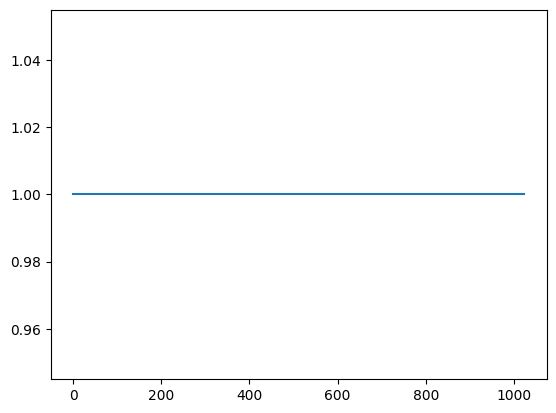

In [887]:
plt.plot(Cd.cd_have_lock)

Text(0, 0.5, 'time')

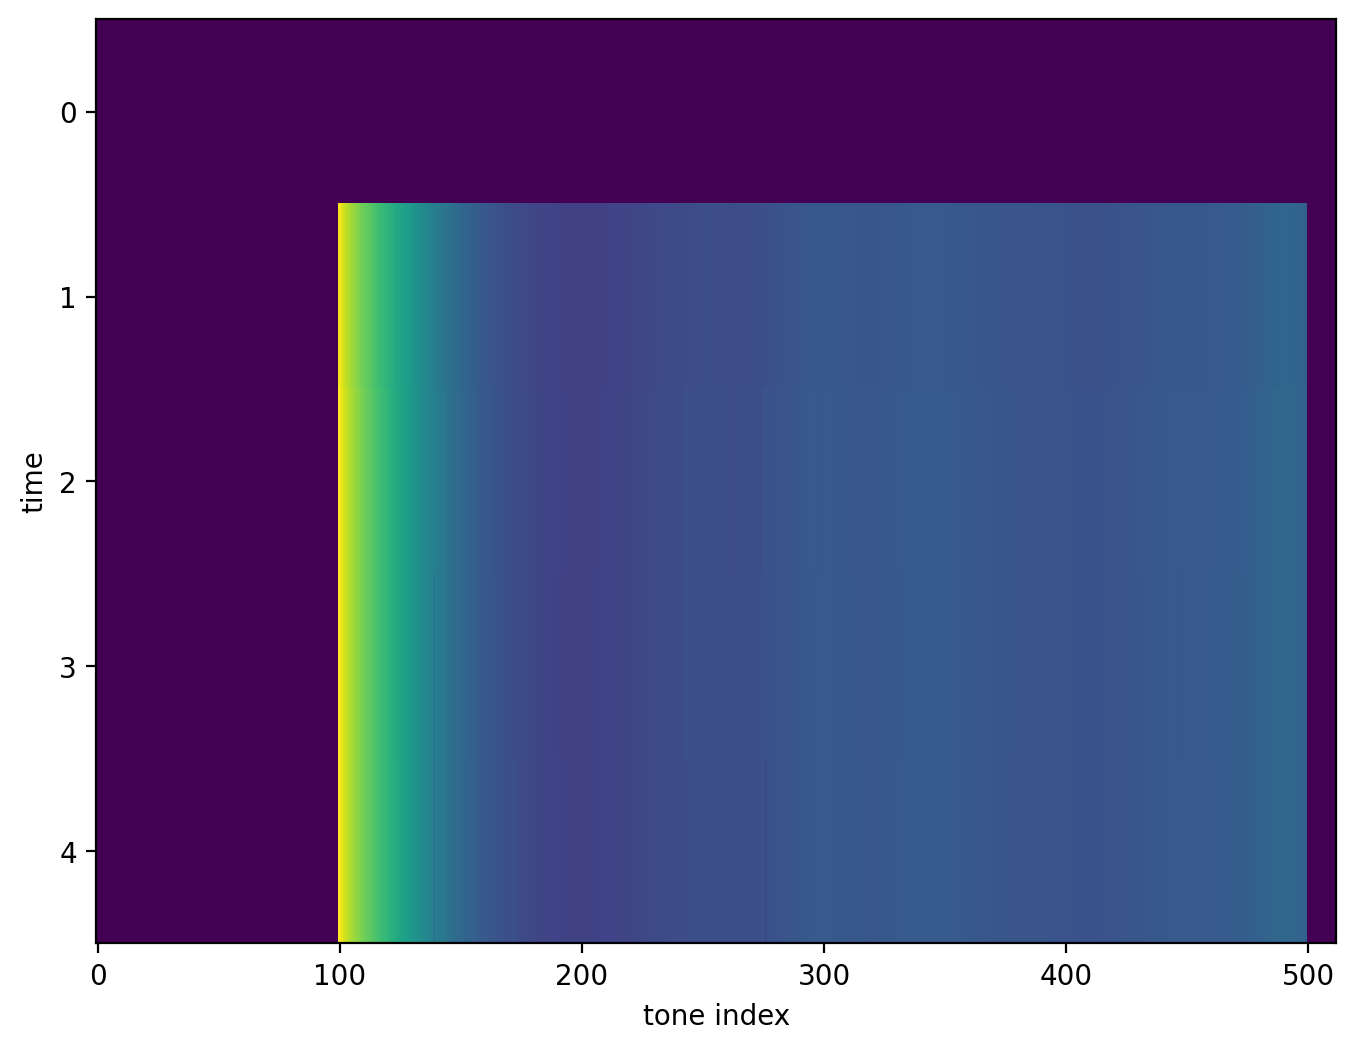

In [872]:
plt.figure(figsize=(8,6),dpi=200)
a = np.abs(C.calib_data[3,:,:])
#plt.figure(figsize=(15,8))
plt.imshow(a,aspect='auto', interpolation='nearest')
plt.xlabel('tone index')
plt.ylabel('time')
#plt.plot(a[:,100])

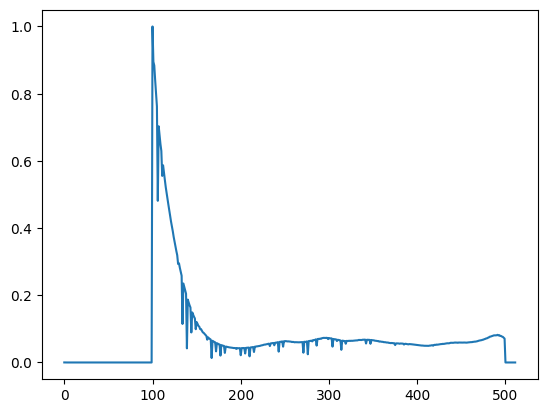

In [873]:

b = np.copy(C.spectra[2][2].data[2::4])

w=(a.mean(axis=0))**2/b
w/=w.max()
plt.plot(w)
#print(b)
#w[139]=0
#w[241]=0
#w[242]=0
#w[276]=0
#w[277]=0
#plt.plot(w)
np.savez('weights.npz',w=w)

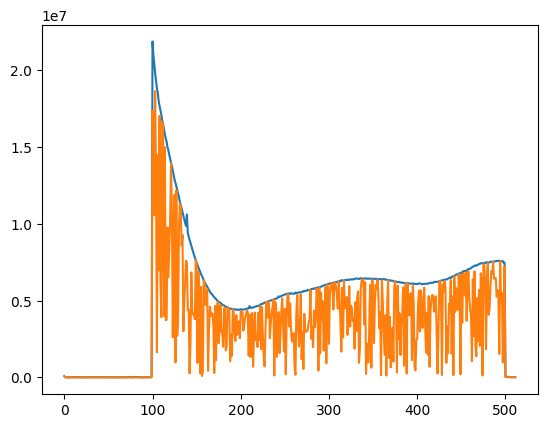

In [309]:
plt.plot(np.max(np.abs(C.calib_data[0]),axis=0))
plt.plot(np.abs(C.calib_data[0,1,:]))

IndexError: list index out of range

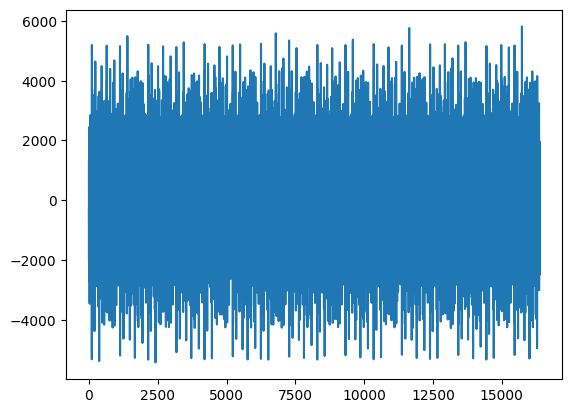

In [469]:
w=[w.waveform for w in C.waveform_packets]
plt.plot(ewf[0])
plt.plot(w[0])


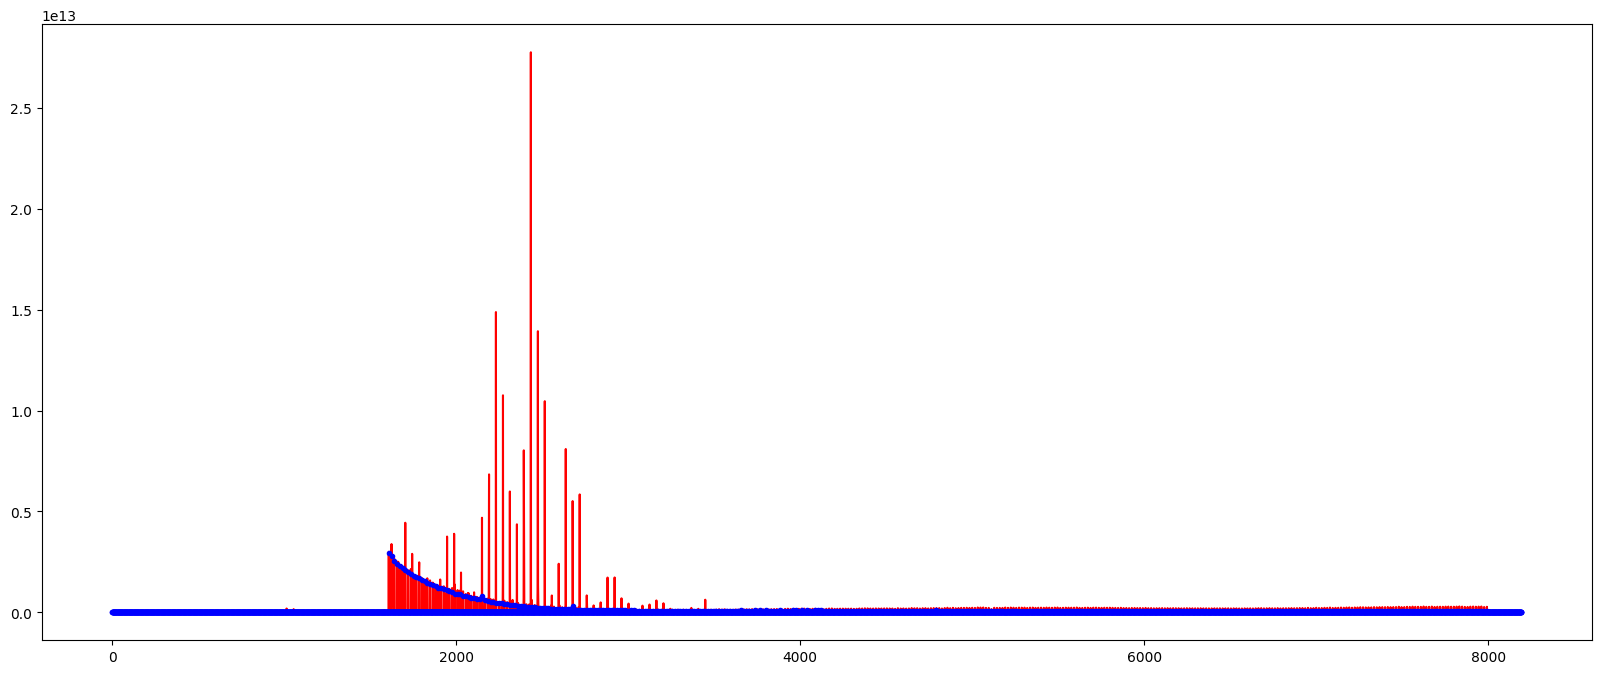

In [58]:
plt.figure(figsize=(20,8))

plt.plot(spec(w[3])*3,'r-')
plt.plot(spec(ewf[3]),'b.')
#plt.xlim(2000,2200)
#plt.semilogy()

In [13]:
for i,v in enumerate(P.registers):
    if (v!=0):
        print (f"Register {i:x}: {v}")

Register 1a: 35755457
Register 3c: 1
Register 4d: 1
Register 50: 128
Register 51: 128
Register 52: 128
Register 53: 128
Register 54: 128
Register 55: 128
Register 56: 128
Register 57: 128
Register 58: 128
Register 59: 128
Register 5a: 128
Register 5b: 128
Register 5c: 128
Register 5d: 128
Register 5e: 128
Register 5f: 128
Register 60: 128
Register 61: 128
Register 62: 128
Register 63: 128
Register 64: 128
Register 65: 128
Register 66: 128
Register 67: 128
Register 68: 128
Register 69: 128
Register 6a: 128
Register 6b: 128
Register 6c: 128
Register 6d: 128
Register 6e: 128
Register 6f: 128
Register 70: 128
Register 71: 128
Register 72: 128
Register 73: 128
Register 74: 128
Register 75: 128
Register 76: 128
Register 77: 128
Register 78: 128
Register 79: 128
Register 7a: 128
Register 7b: 128
Register 7c: 128
Register 7d: 128
Register 7e: 128
Register 7f: 128
Register 80: 128
Register 81: 128
Register 82: 128
Register 83: 128
Register 84: 128
Register 85: 128
Register 86: 128
Register 87: 

In [ ]:

#plt.plot(w[3].waveform)
##plt.plot(w[7].waveform)

In [185]:
d = np.array([S[0].data for S in C.spectra])
d.shape

(2, 2048)

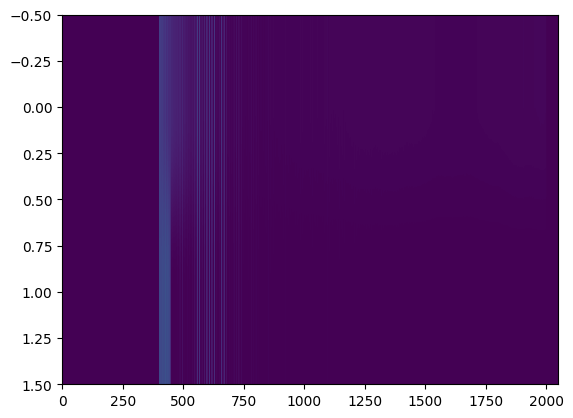

In [186]:
plt.imshow(d,aspect='auto')

(0.0, 100000000.0)

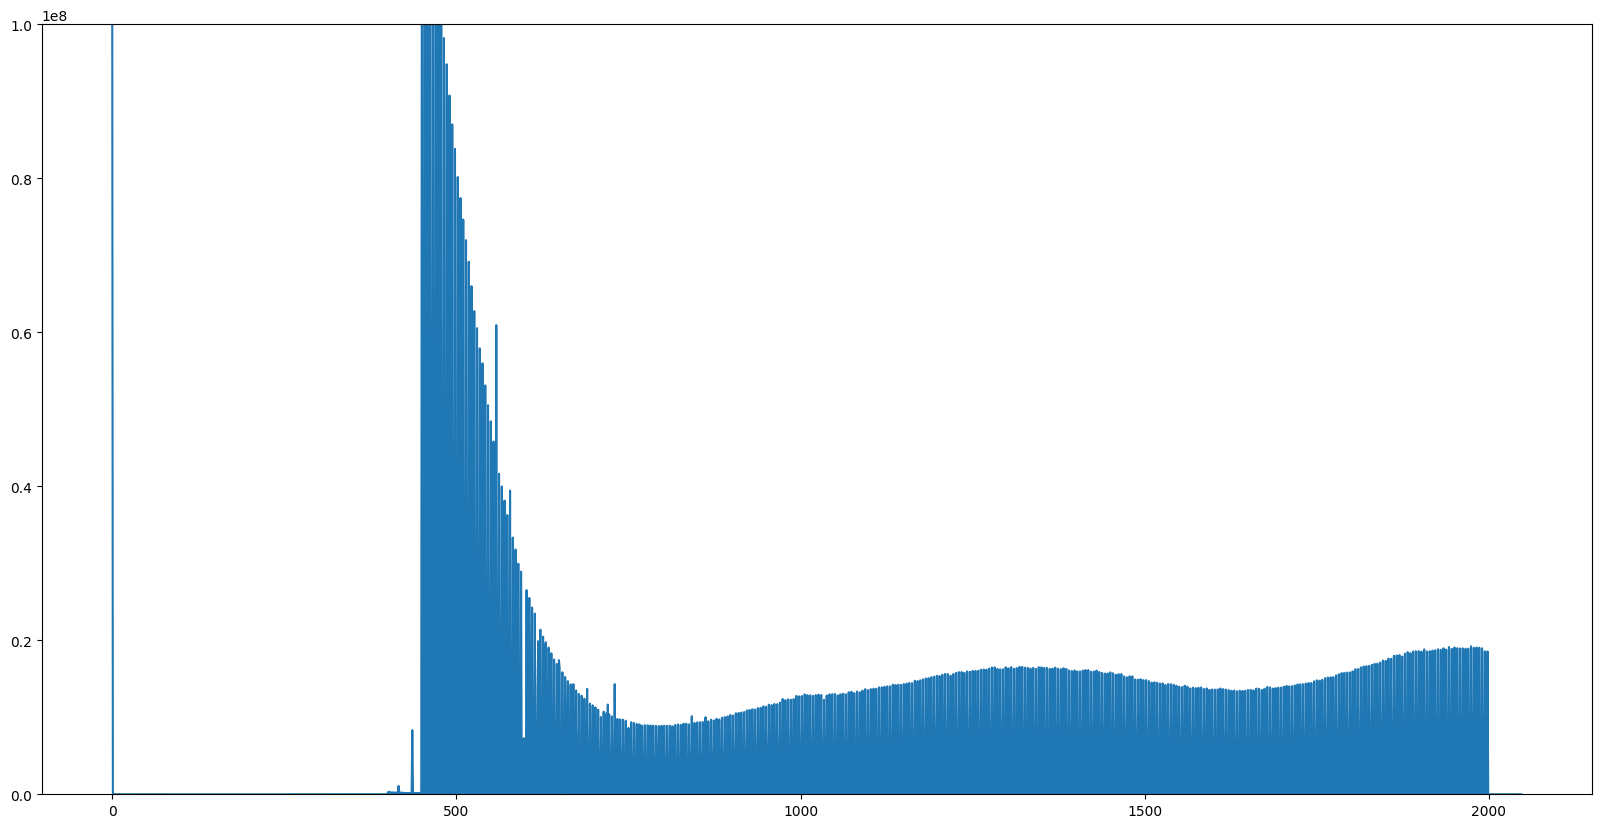

In [205]:
plt.figure(figsize=(20,10))
#
plt.plot(d[0]-d[1])
#plt.plot(d[1])
#plt.xlim(1000,2050)
plt.ylim(0,1e8)
#plt.semilogy()
